<a href="https://colab.research.google.com/github/frankjinn/frankjinn/blob/main/Disaster_Detection_from_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Explorative NLP Project, structure and exploration based on Daniel Bourke's course.

## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script containing our helper functions can be [found on GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-14 16:32:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-14 16:32:57 (70.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

Let's start by download a text dataset. We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) datset from Kaggle which contains text-based Tweets about natural disasters. 

The Real Tweets are actually about diasters, for example:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

The Not Real Tweets are Tweets not about diasters (they can be on anything), for example:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

For convenience, the dataset has been [downloaded from Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (doing this requires a Kaggle account) and uploaded as a downloadable zip file. 

> 🔑 **Note:** The original downloaded data has not been altered to how you would download it from Kaggle.

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-01-14 16:40:24--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-01-14 16:40:24 (112 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset

Once you've acquired a new dataset to work with, what should you do first?

Explore it? Inspect it? Verify it? Become one with it?

All correct.

Remember the motto: visualize, visualize, visualize.

Right now, our text data samples are in the form of `.csv` files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

> 📖 **Reading:** You might come across text datasets in many different formats. Aside from CSV files (what we're working with), you'll probably encounter `.txt` files and `.json` files too. For working with these type of files, I'd recommend reading the two following articles by RealPython:
* [How to Read and Write Files in Python](https://realpython.com/read-write-files-python/)
* [Working with JSON Data in Python](https://realpython.com/python-json/)

In [ ]:
#Turn .csv files into pandas DataFrame
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-text-classification-inputs-and-outputs.png)
*Example text classification inputs and outputs for the problem of classifying whether a Tweet is about a diaster or not.*

In [ ]:
#The test data doesn't have a target
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's check how many examples of each target we have.

In [ ]:
#How many examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where, 

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

And what about the total number of samples we have?

In [ ]:
#How many sampels in total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")


Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Alright, seems like we've got a decent amount of training and test data. If anything, we've got an abundance of testing examples, usually a split of 90/10 (90% training, 10% testing) or 80/20 is suffice.

Okay, time to visualize, let's write some code to visualize random text samples.

> 🤔 **Question:** Why visualize random samples? You could visualize samples in order but this could lead to only seeing a certain subset of data. Better to visualize a substantial quantity (100+) of random samples to get an idea of the different kinds of data you're working with. In machine learning, never underestimate the power of randomness.

In [ ]:
#Lets visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
@WaseemBadami Condemning of Deaths More than 1000 due to Heat Wave in Karachi. 
May Allah gv Patience to their Heirs. http://t.co/iTG84q7vIi

---

Target: 1 (real disaster)
Text:
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

---

Target: 0 (not real disaster)
Text:
Ted Cruz Bashes Obama Comparison GOP To Iranians Shouting 'Death To America' http://t.co/cuFGVupKzi

---

Target: 0 (not real disaster)
Text:
Rip ?? Blood !

---

Target: 1 (real disaster)
Text:
'Er indoors will be devastated. RIP Arfur. #GeorgeCole

---



### Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method and dedicate 10% of the training samples to the validation set.

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state = 42)

In [ ]:
#Check lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
#View first 10
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

Wonderful! We've got a training set and a validation set containing Tweets and labels.

Our labels are in numerical form (`0` and `1`) but our Tweets are in string form.

> 🤔 **Question:** What do you think we have to do before we can use a machine learning algorithm with our text data? 

If you answered something along the lines of "turn it into numbers", you're correct. A machine learning algorithm requires its inputs to be in numerical form.

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tokenization-vs-embedding.png)
*Example of **tokenization** (straight mapping from word to number) and **embedding** (richer representation of relationships between tokens).*

> 🤔 **Question:** What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)). 

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding) are great places to start.

> 🔑 **Note:** Much like searching for a pre-trained computer vision model, you can search for pre-trained word embeddings to use for your problem. Try searching for something like "use pre-trained word embeddings in TensorFlow".

### Text vectorization (tokenization)

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

Let's see it in action.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split = "whitespace",
                                    ngrams = None,
                                    output_mode = "int", # how to map tokens to numbers
                                    output_sequence_length = None) # how long should the output sequence of tokens be?

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [ ]:
#Fine average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
#Now create a custom textvectorization
max_vocab_length = 10000
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

Beautiful!

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [ ]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Training data mapped! Let's try our `text_vectorizer` on a custom sentence (one similar to what you might see in the training data).

In [ ]:
#Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

How about we try our `text_vectorizer` on a few random sentences?

In [ ]:
#Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 I spent 15 minutes lifting weights. 43 calories burned. #LoseIt      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8, 1589,  426, 1271, 5219, 6855, 6323, 2167,  466, 5188,    0,
           0,    0,    0,    0]])>

Looking good!

Finally, we can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [ ]:
#Get the unique wods in teh vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, #set input shape
                             output_dim = 128, #set size of embedding vector
                             input_length = max_length, #how long is each input
                             name = "embedding_1")
embedding

In [ ]:
#Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\n Embedded version:")

#Embed the random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Hollywood Movie About Trapped Miners Released in Chile http://t.co/qkrLtrd39B      

 Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00380983, -0.00078579, -0.02349898, ..., -0.03660506,
          0.00510427, -0.01457458],
        [ 0.00418308,  0.03327287, -0.04578265, ..., -0.0094863 ,
          0.01565054, -0.01241145],
        [ 0.04286158,  0.00544541,  0.04951525, ...,  0.04937804,
          0.02925548, -0.03104466],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [ ]:
#Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.00380983, -0.00078579, -0.02349898, -0.03096451, -0.01977366,
        0.00846728,  0.0040913 ,  0.01579892,  0.03243898, -0.00250083,
       -0.0163155 ,  0.03841783, -0.02943716,  0.02491217, -0.04720824,
       -0.03176563,  0.03121178, -0.04155628,  0.01829816, -0.0228979 ,
        0.01007627,  0.03644873, -0.04026079,  0.04967911, -0.02278479,
        0.04907793,  0.0110432 , -0.0107811 , -0.02546891,  0.02535899,
       -0.008297  , -0.04535199,  0.01695836,  0.04063473, -0.00295492,
       -0.00139928,  0.01931641,  0.04332593,  0.04435935, -0.04465196,
       -0.00593687, -0.01049918, -0.02918067, -0.02004947,  0.02227339,
        0.00202606, -0.01158009, -0.04113424,  0.00140107, -0.02789754,
        0.01125858,  0.04795231,  0.00728998,  0.00251446, -0.04520453,
       -0.02424399, -0.03640171, -0.00868426,  0.04370865, -0.04661671,
       -0.01816978,  0.04221109,  0.00503876, -0.017426  ,  0.04916376,
        0.018927

These values might not mean much to us but they're what our computer sees each word as. When our model looks for patterns in different samples, these values will be updated as necessary.

> 🔑 **Note:** The previous two concepts (tokenization and embeddings) are the foundation for many NLP tasks. So if you're not sure about anything, be sure to research and conduct your own experiments to further help your understanding.

## Modelling a text dataset

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-inputs-and-outputs-with-shapes-and-models-were-going-to-build.png)
*Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.*

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

Let's get started.

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

> 📖 **Reading:** The ins and outs of TF-IDF algorithm is beyond the scope of this notebook, however, the curious reader is encouraged to check out the [Scikit-Learn documentation for more](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization adn modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), #convert words to number using tfidf
                    ("clf", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

Let's evaluate our model and find our baseline metric.

In [ ]:
#lets evaluate it
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100: .2f}%")

Our baseline model achieves an accuracy of:  79.27%


In [ ]:
#Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

> 🔑 **Note:** Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [ ]:
#Function to evaluate: accuracy, precision, recall, f1-scaore
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Retur
  """
  #Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) *100
  #Calcualte model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
#Get baseline results
baseline_results = calculate_resutls(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer. 

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from `helper_functions.py` to keep track of the results of each. 

In [ ]:
#Create tensorboard callback
from helper_functions import create_tensorboard_callback

#Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

Now we've got a TensorBoard callback function ready to go, let's build our first deep model.

In [ ]:
#Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = "string") #inputs are 1-dimensional strings
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
#x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

Note: Flatten seems to work almost as well as the pooling layers, but it overfits

Looking good. Our model takes a 1-dimensional string as input (in our case, a Tweet), it then tokenizes the string using `text_vectorizer` and creates an embedding using `embedding`.

We then (optionally) pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass to the output layer.

> 🛠 **Exercise:** Try building `model_1` with and without a `GlobalAveragePooling1D()` layer after the `embedding` layer. What happens? Why do you think this is?

Finally, we pass the output of the pooling layer to a dense layer with sigmoid activation (we use sigmoid since our problem is binary classification).

Before we can fit our model to the data, we've got to compile it. Since we're working with binary classification, we'll use `"binary_crossentropy"` as our loss function and the Adam optimizer.

In [ ]:
#Compile model
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

Most of the trainable parameters are contained within the embedding layer. Recall we created an embedding of size 128 (`output_dim=128`) for a vocabulary of size 10,000 (`input_dim=10000`), hence the 1,280,000 trainable parameters.

Alright, our model is compiled, let's fit it to our training data for 5 epochs. We'll also pass our TensorBoard callback function to make sure our model's training metrics are logged.

In [ ]:
#Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "simple_dense")])

Saving TensorBoard log files to: model_logs/simple_dense/20220114-182232
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.5137 - accuracy: 0.8285 - val_loss: 0.4985 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3132 - accuracy: 0.9082 - val_loss: 0.4599 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2355 - accuracy: 0.9267 - val_loss: 0.4699 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1935 - accuracy: 0.9390 - val_loss: 0.4898 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1648 - accuracy: 0.9476 - val_loss: 0.5136 - val_accuracy: 0.7848


In [ ]:
#Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.5136 - accuracy: 0.7848


[0.513620913028717, 0.7847769260406494]

In [ ]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.02994066,  0.03915378, -0.02533327, ..., -0.05354938,
          0.05907318, -0.00951542],
        [-0.00871122, -0.04483583, -0.03176949, ..., -0.03942568,
          0.05853965,  0.01322784],
        [ 0.00641275,  0.01721581,  0.03011764, ..., -0.05536195,
          0.02059623,  0.02534183],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.1174048 ,  0.07693215,  0.09882461, ...,  0.01252943,
          0.1007919 ,  0.08286744],
        [ 0.21451704,  0.17497663,  0.17424189, ...,  0.2042488 ,
          0.16125233,  0.13827142]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


This represents that there are 10000 unique words, each represented with an 128 embed vector. You can think of it as a word with 128 resolution. More elements in the embed vector, the more precise the word can be represented. But may lead to overfitting.

And since we tracked our model's training logs with TensorBoard, how about we visualize them?

We can do so by uploading our TensorBoard log files (contained in the `model_logs` directory) to [TensorBoard.dev](https://tensorboard.dev/).

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
#View tensorboard logs of transfer learning modelling experiments (should be 4)
#Upload
!tensorboard dev upload --logdir ./model_logs \
  --name "First deep model on text data"\
  --description "Trying a dense model with an embedding layer"\
  --one_shot

2022-01-14 18:29:14.993597: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%

The TensorBoard.dev experiment for our first deep model can be viewed here: https://tensorboard.dev/experiment/5d1Xm10aT6m6MgyW3HAGfw/

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tensorboard-dense-model-training-curves.png)

*What the training curves of our model look like on TensorBoard. From looking at the curves can you tell if the model is overfitting or underfitting?*

Beautiful! Those are some colorful training curves. Would you say the model is overfitting or underfitting?

We've built and trained our first deep model, the next step is to make some predictions with it.

In [ ]:
#Make predictions (test come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.39082468],
       [0.76599956],
       [0.9981596 ],
       [0.09750202],
       [0.04394719],
       [0.9426303 ],
       [0.880622  ],
       [0.99745506],
       [0.9891937 ],
       [0.33906186]], dtype=float32)

Since our final layer uses a sigmoid activation function, we get our predictions back in the form of probabilities.

To convert them to prediction classes, we'll use `tf.round()`, meaning prediction probabilities below 0.5 will be rounded to 0 and those above 0.5 will be rounded to 1.

> 🔑 **Note:** In practice, the output threshold of a sigmoid prediction probability doesn't necessarily have to 0.5. For example, through testing, you may find that a cut off of 0.25 is better for your chosen evaluation metrics. A common example of this threshold cutoff is the [precision-recall tradeoff](https://www.machinelearningaptitude.com/topics/machine-learning/what-is-precision-recall-tradeoff/#:~:text=precision%2Drecall%20tradeoff%20occur%20due,the%20threshold%20of%20the%20classifier.&text=When%20threshold%20is%20decreased%20to,but%20precision%20decreases%20to%200.4.).

In [ ]:
#Turn prediction probability tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Now we've got our model's predictions in the form of classes, we can use our `calculate_results()` function to compare them to the ground truth validation labels.

In [ ]:
#Calculate model_1 metrics
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'f1': 0.7825760559664451,
 'precision': 0.7873574987198574,
 'recall': 0.7847769028871391}

In [ ]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:
#We can write a function to make it more clear
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]: .2f}, Difference: {new_model_results[key] - value: .2f}")

compare_baseline_to_new_results(baseline_results = baseline_results,
                                new_model_results = model_1_results)

Baseline accuracy: 79.27, New accuracy:  78.48, Difference: -0.79
Baseline precision: 0.81, New precision:  0.79, Difference: -0.02
Baseline recall: 0.79, New recall:  0.78, Difference: -0.01
Baseline f1: 0.79, New f1:  0.78, Difference: -0.00


## Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

To do so, let's remind ourselves of the words in our vocabulary.


In [ ]:
#Get the vocaulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding. 

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).


In [ ]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:
1. Go to  http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (`embedding_vectors.tsv` and `embedding_metadata.tsv`)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"

What do you find?

Are words with similar meanings close together?

Remember, they might not be. The embeddings we downloaded are how our model interprets words, not necessarily how we interpret them. 

Also, since the embedding has been learned purely from Tweets, it may contain some strange values as Tweets are a very unique style of natural language.

> 🤔 **Question:** Do you have to visualize embeddings every time?

No. Although helpful for gaining an intuition of what natural language embeddings are, it's not completely necessary. Especially as the dimensions of your vocabulary and embeddings grow, trying to comprehend them would become an increasingly difficult task.

## Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog. 

See what happened there? 

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence. 

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

Going into the details of each these is beyond the scope of this notebook (we're going to focus on using them instead), the main thing you should know for now is that they've proven very effective at modelling sequences.

For a deeper understanding of what's happening behind the scenes of the code we're about to write, I'd recommend the following resources:

> 📖 **Resources:**
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.


### Model 2: LSTM

With all this talk of what RNN's are and what they're good for, I'm sure you're eager to build one.

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)
*Coloured block example of the structure of an recurrent neural network.*

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [ ]:
#Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                    output_dim = 128,
                                    embeddings_initializer = "uniform",
                                    input_length = max_length,
                                    name = "embedding_2")
#Create LSTM model
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")

(None, 15, 128)
(None, 64)


> 🔑 **Note:** Reading the documentation for the [TensorFlow LSTM layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), you'll find a plethora of parameters. Many of these have been tuned to make sure they compute as fast as possible. The main ones you'll be looking to adjust are `units` (number of hidden units) and `return_sequences` (set this to `True` when stacking LSTM or other recurrent layers).

Now we've got our LSTM model built, let's compile it using `"binary_crossentropy"` loss and the Adam optimizer.

In [ ]:
#Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

Looking good! You'll notice a fair few more trainable parameters within our LSTM layer than `model_1`. 

If you'd like to know where this number comes from, I recommend going through the above resources as well the following on calculating the number of parameters in an LSTM cell:
* [Stack Overflow answer to calculate the number of parameters in an LSTM cell](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network) by Marcin Możejko
* [Calculating number of parameters in a LSTM unit and layer](https://medium.com/@priyadarshi.cse/calculating-number-of-parameters-in-a-lstm-unit-layer-7e491978e1e4) by Shridhar Priyadarshi

Now our first RNN model's compiled let's fit it to our training data, validating it on the validation data and tracking its training parameters using our TensorBoard callback.

In [ ]:
#fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220114-192245
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


Nice! We've got our first trained RNN model using LSTM cells. Let's make some predictions with it.

The same thing will happen as before, due to the sigmoid activiation function in the final layer, when we call the `predict()` method on our model, it'll return prediction probabilities rather than classes.

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[0.00712615],
        [0.7873689 ],
        [0.9996376 ],
        [0.05679163],
        [0.00258216],
        [0.99962384],
        [0.9217019 ],
        [0.9997994 ],
        [0.99949545],
        [0.66457486]], dtype=float32))

In [ ]:
#Round out predictions and reduce
model_2_preds = tf.round(tf.squeeze(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Beautiful, now let's use our `caculate_results()` function to evaluate our LSTM model and our `compare_baseline_to_new_results()` function to compare it to our baseline model.

In [ ]:
#Calculate LSTM model results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'f1': 0.7489268622514025,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026}

In [ ]:
#Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy:  75.07, Difference: -4.20
Baseline precision: 0.81, New precision:  0.75, Difference: -0.06
Baseline recall: 0.79, New recall:  0.75, Difference: -0.04
Baseline f1: 0.79, New f1:  0.75, Difference: -0.04


### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Resource:** A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
#Compile
model_3.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

We'll fit our model just as we've been doing previously. We'll also track our models results using our `create_tensorboard_callback()` function.

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220114-193926
Epoch 1/5
215/215 [==============================] - 9s 30ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [ ]:
#Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[0.333252  ],
        [0.877412  ],
        [0.9980252 ],
        [0.11561716],
        [0.01235956],
        [0.9925637 ],
        [0.6214276 ],
        [0.9981333 ],
        [0.9982377 ],
        [0.50181204]], dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
#Get results
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7667932666650168,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy:  76.77, Difference: -2.49
Baseline precision: 0.81, New precision:  0.77, Difference: -0.04
Baseline recall: 0.79, New recall:  0.77, Difference: -0.02
Baseline f1: 0.79, New f1:  0.77, Difference: -0.02


### Model 4: Bidirectonal RNN model 

Look at us go! We've already built two RNN's with GRU and LSTM cells. Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Okay enough talk, let's build a bidirectional RNN.

Once again, TensorFlow helps us out by providing the [`tensorflow.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     input_length = max_length,
                                     name = "embedding_4")

#Build a bidirectional RNN in Tensorflow
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

> 🔑 **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

Our bidirectional model is built, let's compile it.

In [ ]:
#Compile
model_4.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
#Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220114-194733
Epoch 1/5
215/215 [==============================] - 13s 42ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


Due to the bidirectionality of our model we see a slight increase in training time.

Not to worry, it's not too dramatic of an increase.

Let's make some predictions with it.

In [ ]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.04000095],
       [0.82792675],
       [0.99842227],
       [0.13531172],
       [0.00311336],
       [0.9922074 ],
       [0.9552848 ],
       [0.9994564 ],
       [0.99898285],
       [0.28141806]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7651213533864446,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657}

In [ ]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy:  76.64, Difference: -2.62
Baseline precision: 0.81, New precision:  0.77, Difference: -0.04
Baseline recall: 0.79, New recall:  0.77, Difference: -0.03
Baseline f1: 0.79, New f1:  0.77, Difference: -0.02


## Convolutional Neural Networks for Text

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following: 

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

You might be thinking "that just looks like the architecture layout we've been using for the other models..."

And you'd be right.

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

> 


### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a **temporal convolution**) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [ ]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (`input_length=15` and `output_dim=128`).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

Let's take a peak at what each of these transformations looks like.

In [ ]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.03261314, -0.04542834,  0.01329945, ..., -0.02487622,
           0.00914541, -0.0481565 ],
         [-0.069736  ,  0.08694722,  0.09315822, ...,  0.01005595,
           0.04589253,  0.11995432],
         [-0.0894013 , -0.06415088, -0.01318773, ..., -0.00338307,
           0.03606163,  0.06192124],
         ...,
         [-0.02994066,  0.03915378, -0.02533327, ..., -0.05354938,
           0.05907318, -0.00951542],
         [-0.02994066,  0.03915378, -0.02533327, ..., -0.05354938,
           0.05907318, -0.00951542],
         [-0.02994066,  0.03915378, -0.02533327, ..., -0.05354938,
           0.05907318, -0.00951542]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.14053018, 0.0894354 , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.01239408, 0.05733011, 0.16176885,
          0.07342827, 0.03586474, 0.10435013, 0.00307628, 0.01671728,
          0.        , 0.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220114-195840
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.22534508],
       [0.75341123],
       [0.99956024],
       [0.05562782],
       [0.01449853],
       [0.98585176],
       [0.9841893 ],
       [0.99758804],
       [0.9986262 ],
       [0.26914358]], dtype=float32)

In [ ]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'f1': 0.7758810170952618,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129}

In [ ]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy:  77.82, Difference: -1.44
Baseline precision: 0.81, New precision:  0.78, Difference: -0.03
Baseline recall: 0.79, New recall:  0.78, Difference: -0.01
Baseline f1: 0.79, New f1:  0.78, Difference: -0.01


## Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

> 🔑 **Note:** There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.



### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)
*The feature extractor model we're building through the eyes of an **encoder/decoder** model.*

> 🔑 **Note:** An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.

As usual, this is best demonstrated with an example.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589839 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874646 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787357  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195373  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

> 🔑 **Note:** Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a ["lite" version of the USE](https://tfhub.dev/google/universal-sentence-encoder-lite/2) which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_16 (Dense)            (None, 64)                32832     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the [Universal Sentence Encoder paper](https://www.aclweb.org/anthology/D18-2029.pdf) for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting `trainable=True` when creating the `hub.KerasLayer` instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our `create_tensorboard_callback()` function.

In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220114-200500
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [ ]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.14443198],
       [0.7271504 ],
       [0.98566544],
       [0.19740924],
       [0.7341702 ],
       [0.68596613],
       [0.98088884],
       [0.97411025],
       [0.91573226],
       [0.08070084]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.810686575717776,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy:  81.23, Difference:  1.97
Baseline precision: 0.81, New precision:  0.81, Difference:  0.00
Baseline recall: 0.79, New recall:  0.81, Difference:  0.02
Baseline f1: 0.79, New f1:  0.81, Difference:  0.02


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [ ]:
len(train_labels)

6851

In [ ]:
# ## NOTE: Making splits like this will lead to data leakage ###
# ## (some of the training examples in the validation set) ###

# ## WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [ ]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


Because we've selected a random subset of the training samples, the classes should be roughly balanced (as they are in the full training dataset).

In [ ]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (`model_6`) using the [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [ ]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_16 (Dense)            (None, 64)                32832     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20220114-202407
Epoch 1/5
22/22 [==============================] - 4s 47ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.24043253],
       [0.7683784 ],
       [0.9013718 ],
       [0.29067963],
       [0.5714997 ],
       [0.8356512 ],
       [0.8062943 ],
       [0.83358157],
       [0.8554567 ],
       [0.11749935]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'f1': 0.7667059443150692,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy:  77.03, Difference: -2.23
Baseline precision: 0.81, New precision:  0.78, Difference: -0.04
Baseline recall: 0.79, New recall:  0.77, Difference: -0.02
Baseline f1: 0.79, New f1:  0.77, Difference: -0.02


## Comparing the performance of each of our models

Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for `model_7` where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.477690,0.787357,0.784777,0.782576
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.034121,0.775563,0.770341,0.766706


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

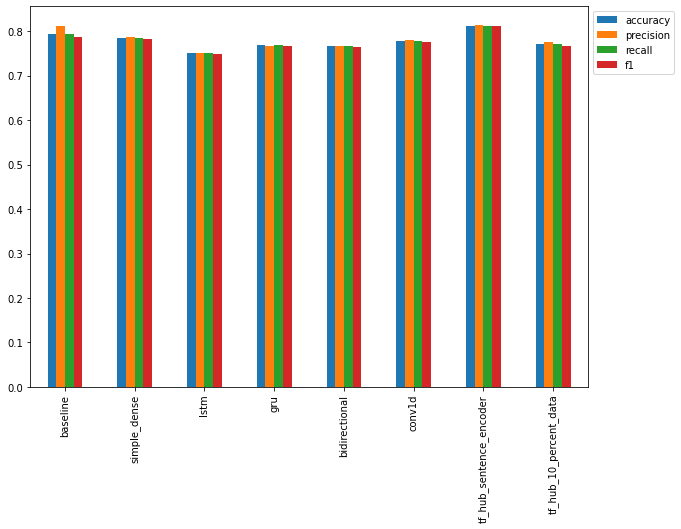

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Looks like our pretrained USE TensorFlow Hub models have the best performance, even the one with only 10% of the training data seems to outperform the other models. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

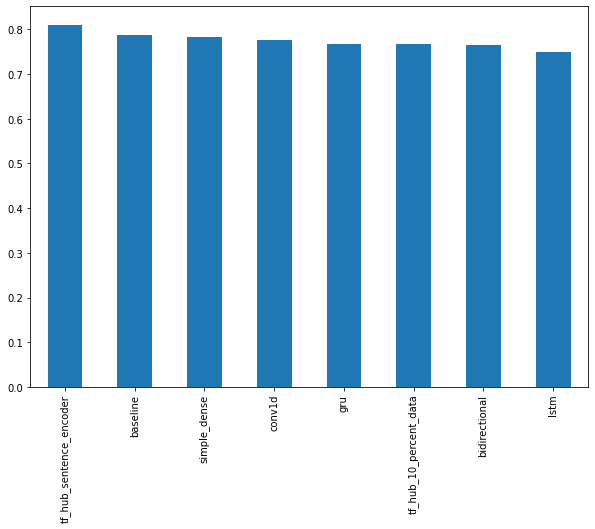

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Drilling down into a single metric we see our USE TensorFlow Hub models performing  better than all of the other models. Interestingly, the baseline's F1-score isn't too far off the rest of the deeper models.

We can also visualize all of our model's training logs using TensorBoard.dev.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
  --name "NLP modelling experiments" \
  --description "A series of different NLP modellings experiments with various models" \
  --one_shot # exits the uploader when upload has finished

2022-01-14 20:28:48.887242: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ias20twnRB6Uelg09NrZhQ/

[2022-01-14T20:28:49] Started scanning logdir.
[2022-01-14T20:28:58] Total uploaded: 270 scalars, 0 tensors, 9 binary objects (2.9 MB)
[2022-01-14T20:28:58] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/ias20twnRB6Uelg09NrZhQ/


## Combining our models (model ensembling/stacking)

Many production systems use an **ensemble** (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is **uncorrelated**, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)** - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict `[1, 0, 1]` respectively, the majority class is `1`, therefore, that would be the predicted label.
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.

> 📖 **Resource:** The above methods for model stacking/ensembling were adapted from Chapter 6 of the [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) by Andriy Burkov. If you're looking to enter the field of machine learning engineering, not only building models but production-scale machine learning systems, I'd highly recommend reading it in its entirety.

Again, the concept of model stacking is best seen in action.

We're going to combine our baseline model (`model_0`), LSTM model (`model_2`) and our USE model trained on the full training data (`model_6`) by averaging the combined prediction probabilities of each.

##Averaging method

In [ ]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Wonderful! We've got a combined predictions array of different classes, let's evaluate them against the true labels and add our stacked model's results to our `all_model_results` DataFrame.

In [ ]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'f1': 0.7805169025578647,
 'precision': 0.7805216999297674,
 'recall': 0.7808398950131233}

In [ ]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [ ]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.784777,0.787357,0.784777,0.782576
lstm,0.750656,0.751008,0.750656,0.748927
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
tf_hub_10_percent_data,0.770341,0.775563,0.770341,0.766706
ensemble_results,0.780840,0.780522,0.780840,0.780517


How did the stacked model go against the other models?

> 🔑 **Note:** It seems many of our model's results are similar. This may mean there are some limitations to what can be learned from our data. When many of your modelling experiments return similar results, it's a good idea to revisit your data, we'll do this shortly.

## Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format. 
2. The `SavedModel` format (default).

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


As you can see saving and loading our model with either format results in the same performance.

> 🤔 **Question:** Should you used the `SavedModel` format or `HDF5` format?

For most use cases, the `SavedModel` format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, `HDF5` might be better. For more, check out the [TensorFlow documentation on saving and loading models](https://www.tensorflow.org/tutorials/keras/save_and_load).

## Finding the most wrong examples

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong? 
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144432
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.727150
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985665
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197409
4,Radiation emergency #preparedness starts with ...,1,1.0,0.734170


Oh yeah! Now let's find our model's wrong predictions (where `target != pred`) and sort them by their prediction probability (the `pred_prob` column).

In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910481
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864676
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.837961
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.836361
628,@noah_anyname That's where the concentration c...,0,1.0,0.835225
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834875
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.800890
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.782611
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782433
144,The Sound of Arson,0,1.0,0.771343


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9104808568954468
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8646756410598755
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.837960958480835
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8363614082336426
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8352251052856445
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8348746299743652
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Pro

In [ ]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06304338574409485
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.06279498338699341
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.060608088970184326
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.05731779336929321
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04535546898841858
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04145139455795288
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03926113247871399
Text:
@SoonerMagic_ I mean I'm a fan but 

Do you notice anything interesting about the most wrong samples?

Are the ground truth labels correct? What do you think would happen if we went back and corrected the labels which aren't?

## Making predictions on the test dataset

Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [ ]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 0, Prob: 0.0420396625995636
Text:
that exploded &amp; brought about the
beginning of universe matches what's
mentioned in the versethe heaven and Earth
(thus the universe)

----

Pred: 0, Prob: 0.11160147190093994
Text:
Idk if ithats thunder or people rolling in their trashcans ??????

----

Pred: 1, Prob: 0.9347801804542542
Text:
3 cars of #Metro train ready to go into service derailed near #Smithsonian station disrupting service. No injuries. More at noon @wusa9

----

Pred: 0, Prob: 0.36190277338027954
Text:
who sank all night in submarine light of BickfordÛªs floated out and sat through the stale beer afternoon in desolate FugazziÛªs

----

Pred: 1, Prob: 0.8749631643295288
Text:
@PamelaMueller @TIME  It is an honour  and privlege to pray. I have witnessed these bush fires when living in Australia

----

Pred: 0, Prob: 0.041986048221588135
Text:
Mental health is real..?? Self harm is real..??Depression is real..?? feeling alone..?? no where to fit in..?? one day it could be

## Predicting on Tweets from the wild

How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

To start, let's take one of my own [Tweets on living life like an ensemble model](https://twitter.com/mrdbourke/status/1313649328351662082). 

In [ ]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

Great! Time to test our model out.

In [ ]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

Pred: 0.0 (not real disaster) Prob: 0.046233952045440674
Text:
Life like an ensemble: take the best choices from others and make your own


In [ ]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [ ]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9625465869903564
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [ ]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9678558111190796
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


Looks like our model is performing as expected, predicting both of the diaster Tweets as actual diasters.

> 🔑 **Note:** The above examples are cherry-picked and are cases where you'd expect a model to function at high performance. For actual production systems, you'll want to continaully perform tests to see how your model is performing.

## The speed/score tradeoff

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model. 

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [ ]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

Looking good!

Now let's use our `pred_timer()` function to evaluate the prediction times of our best performing model (`model_6`) and our baseline model (`model_0`).

In [ ]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.28055556199979037, 0.00036818315223069605)

In [ ]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.020794153000679216, 2.728891469905409e-05)

It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.

Is that extra prediction time worth it?

Let's compare time per prediction versus our model's F1-scores.

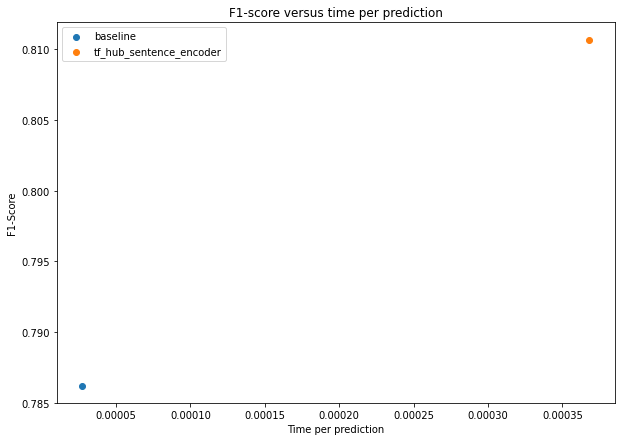

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");